In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/home/cathu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import classification_report

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force l'entraînement sur CPU si pas de GPU dispo

import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments

## Etape 1 : Chargement et exploration du dataset ISOT

Aperçu des données :
                                                   title  \
22216  Ben Stein Calls Out 9th Circuit Court: Committ...   
27917  Trump drops Steve Bannon from National Securit...   
25007  Puerto Rico expects U.S. to lift Jones Act shi...   
1377    OOPS: Trump Just Accidentally Confirmed He Le...   
32476  Donald Trump heads for Scotland to reopen a go...   

                                                    text       subject  \
22216  21st Century Wire says Ben Stein, reputable pr...       US_News   
27917  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
25007  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
1377   On Monday, Donald Trump once again embarrassed...          News   
32476  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                      date  label  
22216    February 13, 2017      0  
27917       April 5, 2017       1  
25007  September 27, 2017       1  
1377          May 22, 2017   

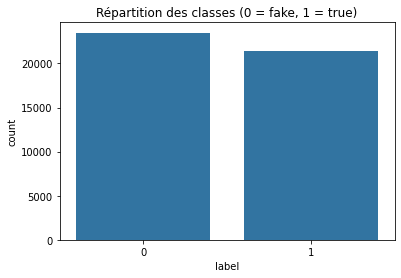

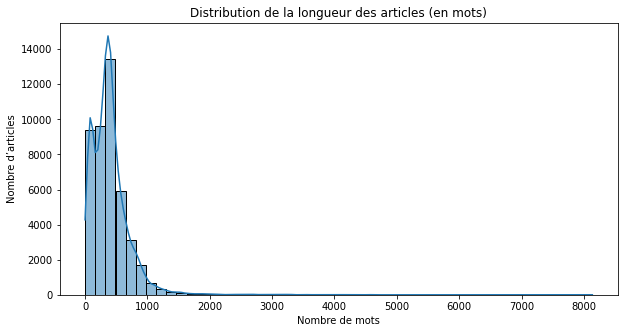

In [7]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Ajout de la colonne 'label'
fake_df["label"] = 0
true_df["label"] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)

print("Aperçu des données :")
print(df.sample(5, random_state=42))

print("\nNombre total d'articles :", len(df))
print("Nombre de fake news :", sum(df["label"] == 0))
print("Nombre de true news :", sum(df["label"] == 1))

df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))
print("\nStatistiques sur la longueur des textes :")
print(df["text_length"].describe())

# Distribution visuelle des classes
sns.countplot(x="label", data=df)
plt.title("Répartition des classes (0 = fake, 1 = true)")
plt.show()

# Distribution des longueurs de texte
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution de la longueur des articles (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d’articles")
plt.show()


## Etape 2 : Prétraitement

In [8]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def simple_preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()  # Remplace word_tokenize()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].astype(str).apply(simple_preprocess)


[nltk_data] Downloading package stopwords to /home/cathu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cathu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
output_path = "ISOT_cleaned.csv"
df.to_csv(output_path, index=False)

## Étape 3 : Modèle de base (Baseline)

In [10]:
df_cleaned = pd.read_csv("ISOT_cleaned.csv")
df_cleaned = df_cleaned.dropna(subset=["clean_text"])
df_cleaned["clean_text"] = df_cleaned["clean_text"].astype(str)

X = df_cleaned["clean_text"]
y = df_cleaned["label"]

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

/home/cathu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


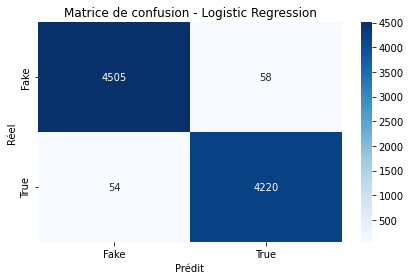

,0,1,accuracy,macro avg,weighted avg
Logistic Regression,"{'precision': 0.9881552972143014, 'recall': 0....","{'precision': 0.9864422627395979, 'recall': 0....",0.987326,"{'precision': 0.9872987799769497, 'recall': 0....","{'precision': 0.9873267910080229, 'recall': 0...."
Naive Bayes,"{'precision': 0.9290210549164315, 'recall': 0....","{'precision': 0.933096926713948, 'recall': 0.9...",0.930972,"{'precision': 0.9310589908151897, 'recall': 0....","{'precision': 0.930992343369819, 'recall': 0.9..."
Linear SVM,"{'precision': 0.9945211483673022, 'recall': 0....","{'precision': 0.9941506785212916, 'recall': 0....",0.994342,"{'precision': 0.9943359134442968, 'recall': 0....","{'precision': 0.994341971257214, 'recall': 0.9..."


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    reports[name] = classification_report(y_test, y_pred, output_dict=True)

#Matrice de confusion
chosen_model = models["Logistic Regression"]
y_pred = chosen_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.title("Matrice de confusion - Logistic Regression")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

report_df = pd.DataFrame(reports).T

report_df.round(3)


|           | Prédit FAKE | Prédit TRUE |
| --------- | ----------- | ----------- |
| Réel FAKE | **4505**    | 58          |
| Réel TRUE | 54          | **4220**    |


In [22]:
((58+54)/(58+54+4505+4220))*100

1.267398438384067

La matrice de confusion indique que le modèle de régression logistique obtient des performances remarquables avec une matrice de confusion montrant un équilibre quasi parfait entre vraies et fausses prédictions. Il commet moins de 1,3 % d’erreurs de classification, ce qui en fait une solide baseline pour évaluer les modèles de type transformer.

In [12]:
report_df.to_csv("report_classic.csv")

## Étape 4 : Modèle avancé (BERT)

In [ ]:
df = pd.read_csv("ISOT_cleaned.csv")
df = df[["clean_text", "label"]].dropna()
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42, stratify=df["label"]
)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = FakeNewsDataset(train_texts, train_labels)
val_dataset = FakeNewsDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:

# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer without transformers
optimizer = AdamW(model.parameters(), lr=2e-5)

# simple training
model.train()
for epoch in range(2):  # nb epoch
    print(f"\nEpoch {epoch+1}")
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Batch loss: {loss.item():.4f}")

In [ ]:
model.eval()
preds, true_labels = [], []

In [ ]:
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, preds, target_names=["Fake", "True"]))